In [17]:
# Standard Imports
import sys
import warnings
sys.path.append("scripts")
warnings.filterwarnings("ignore")

# Relative Imports
from scripts import *

# The input sound is initially binaural, keeping both channels to be able to play it
sound = load_sound("Hedwig's Theme.wav", monaural=False)

Loaded sound "..\data\monophony\Hedwig's Theme.wav"
Duration: 6.528 s, samples: 313344, samplerate: 48. kHz


In [18]:
sound.play(sleep=True)

In [19]:
# For the rest of the implementation, monaural sound is needed. Use only the left channel
sound = sound.left

# Add white noise
noise_level = 0.0005
sound = add_white_noise(sound, noise_level)
save_sound(sound, "Hedwig's Theme Noised.wav")

In [20]:
n_channels = 128
cochleagram = compute_cochleagram(sound, n_channels)
print(f"Cochleagram shape: {cochleagram.shape}")

Cochleagram shape: (128, 313344)


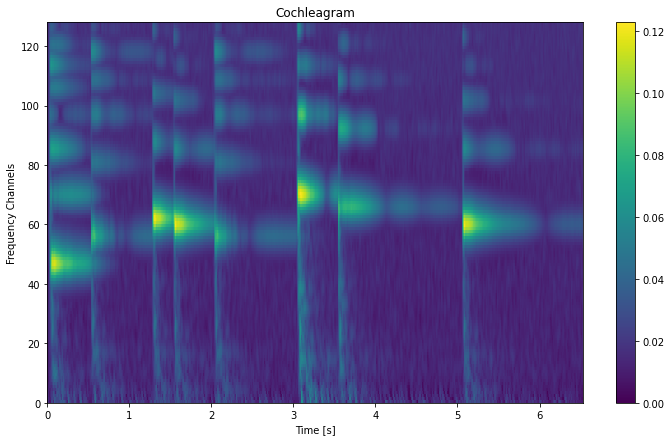

In [21]:
plot_cochleagram(cochleagram, sound.samplerate)

In [22]:
print(f"Applying windowing to {sound.nsamples} samples:\n")

windows = apply_windowing(cochleagram, sound.samplerate)

print(f"Size: {WINDOW_SIZE_MS} ({windows.shape[2]} samples), "
      f"window shape: {windows.shape[1:]}\n"
      f"Overlap: {WINDOW_OVERLAP_MS} ({int(WINDOW_OVERLAP_MS * sound.samplerate)} samples)\n"
      f"Shape of the result: {windows.shape}")

Applying windowing to 313344 samples:

Size: 20. ms (960 samples), window shape: (128, 960)
Overlap: 10. ms (480 samples)
Shape of the result: (651, 128, 960)


In [23]:
# from scipy.ndimage import gaussian_filter
# sigma = 5
# filtered_gaussian = np.apply_along_axis(lambda vec: gaussian_filter(vec, sigma), 0, rmsed)
#
# print(f"Shape of the filtered windows: {filtered_gaussian.shape}")
# img = ax2.imshow(filtered_gaussian, origin='lower', aspect='auto', vmin=0, interpolation="none")
# ax2.set_title("Filtered windows:", fontsize=16)
# ax2.set_xlabel("Time frames")
# ax2.set_ylabel("Channels")
# fig.colorbar(img, ax=ax2)
# show()

In [24]:
# Correlogram (autocorrelation)
correlogram = compute_acf(windows)
print(f"Correlogram shape: {correlogram.shape}")

# Cross-channel correlation coefficients (Pearson's)
ccc = compute_ccc(correlogram)
print(f"Cross-channel correlation shape: {ccc.shape}")

# Summary autocorrelation function
sacf = compute_sacf(correlogram)
print(f"Summary autocorrelation shape: {sacf.shape}")

Correlogram shape: (651, 128, 960)
Cross-channel correlation shape: (651, 128)
Summary autocorrelation shape: (651, 960)


In [25]:
# Harmonics of the fundamental frequency ~ max sum of SACF values
n_harmonics = 10
fundamental_lags, fundamental_frequencies = find_fundamental_frequencies(sacf, sound.samplerate, n_harmonics)
print(f"Fundamental lags shape: {fundamental_lags.shape}")
print(f"Fundamental frequencies shape: {fundamental_frequencies.shape}")

Fundamental lags shape: (651,)
Fundamental frequencies shape: (651,)


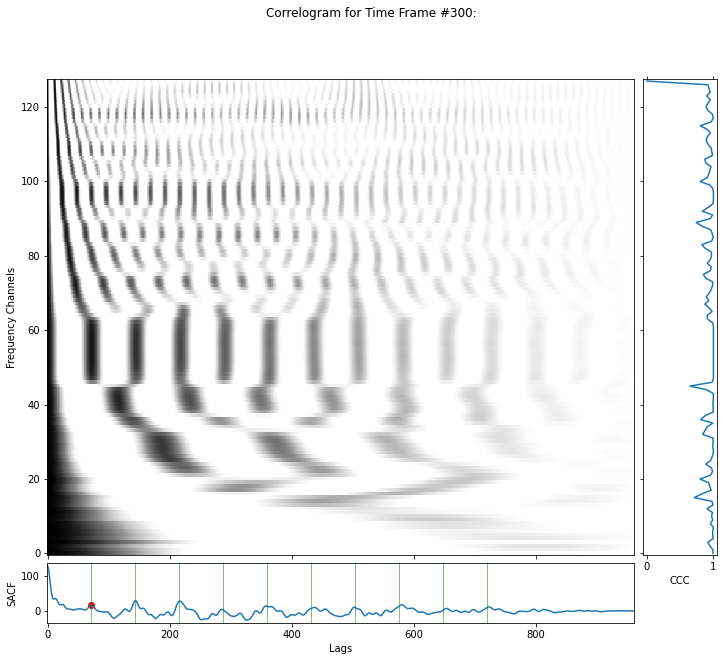

In [26]:
window_num = 300
n_harmonics = 10
plot_correlogram(correlogram, window_num, sound.samplerate, show_f0=True, show_harmonics=True, n_harmonics=n_harmonics)

In [27]:
# Ideal Binary Mask estimate
ccc_threshold = 0.95
agreement_threshold = 0.9
ibm = compute_ibm(correlogram, ccc_threshold, agreement_threshold, fundamental_lags, sound.samplerate)
print(f"Ideal binary mask shape: {ibm.shape}")

Ideal binary mask shape: (651, 128)


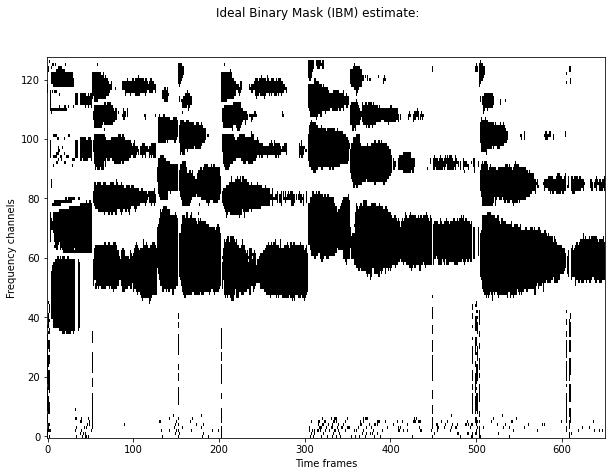

In [28]:
plot_ibm(ibm)

In [29]:
masked_cochleagram = apply_mask(cochleagram, ibm, sound.samplerate)
print(f"Masked cochleagram shape: {masked_cochleagram.shape}")

Masked cochleagram shape: (128, 313344)


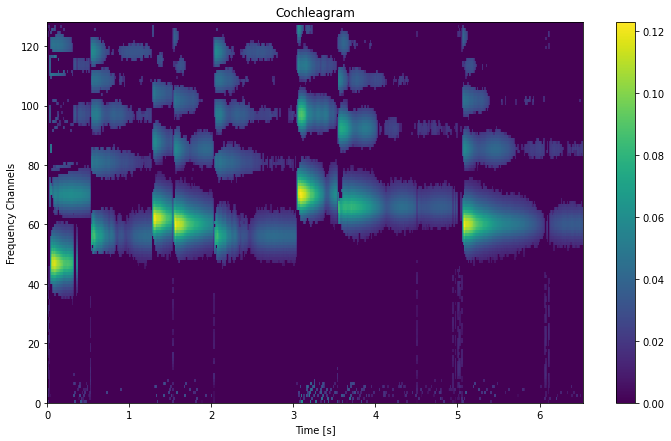

In [30]:
plot_cochleagram(masked_cochleagram, sound.samplerate)

In [31]:
resynth = resynthesize_sound(masked_cochleagram, sound.samplerate)
save_sound(resynth, "Hedwig's Theme.wav")

In [32]:
# To be able to play the resynthesized sound, add second channel
resynth = convert_to_binaural(resynth)
resynth.play()